# Install Python packages

In [ ]:
!pip install swifter

!pip install -q git+https://github.com/tensorflow/docs

# Import Python packages

In [ ]:
import tarfile, re, string, os, nltk, swifter, scipy

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer

from gensim.models import LdaModel
from gensim import corpora

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from google.colab import drive
from unicodedata import normalize
from collections import OrderedDict
from tensorflow import keras
from pathlib import Path

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

import tensorflow_docs.modeling
import tensorflow_docs.plots

# Define functions

In [ ]:
def extract_gzip(file_path, output_path):
  with tarfile.open(file_path, "r:gz") as f: f.extractall(output_path)

def blacklist_words(tokens, blacklist):
  return [t for t in tokens if t not in blacklist]

def whitelist_words(tokens, whitelist):
  return [t for t in tokens if t in whitelist]

def stem_words(tokens, stemmer):
  tokens = [stemmer.stem(t) for t in tokens]

  return [t for t in tokens if len(t) > 1]

def preprocess_text (text, stemmer, stop_words, encoding, re_printable, re_punctuation):
  # normalize unicode as ascii
  text = normalize('NFD', text).encode('ascii', 'ignore')

  # encode text back to normal
  text = text.decode(encoding)

  # replace whitespace with space
  text = re.sub('\s', ' ', text)

  # remove non printable
  text = re_printable.sub('', text)

  # strip text and lower case it
  text = text.strip().lower()

  # remove urls
  text = re.sub(r"\b((?:[a-z][\w-]+://|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|uk)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|uk)\b/?(?!@)))", '', text, flags=re.IGNORECASE)

  # remove emails
  text = re.sub(r"(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', text, flags=re.IGNORECASE)

  # remove numbers
  text = re.sub('\d+', '', text)

  # fix text based on specific contractions
  text = re.sub(r"(W|w)on(\'|\’)t", "will not", text, flags=re.IGNORECASE)
  text = re.sub(r"(C|c)an(\'|\’)t", "can not", text, flags=re.IGNORECASE)
  text = re.sub(r"(Y|y)(\'|\’)all", "you all", text, flags=re.IGNORECASE)
  text = re.sub(r"(Y|y)a(\'|\’)ll", "you all", text, flags=re.IGNORECASE)

  # fix text based on general contractions
  text = re.sub(r"(I|i)(\'|\’)m", "i am", text, flags=re.IGNORECASE)
  text = re.sub(r"(A|a)in(\'|\’)t", "is not", text, flags=re.IGNORECASE)
  text = re.sub(r"n(\'|\’)t", " not", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)re", " are", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)s", " is", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)d", " would", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)ll", " will", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)t", " not", text, flags=re.IGNORECASE)
  text = re.sub(r"(\'|\’)ve", " have", text, flags=re.IGNORECASE)

  # collapse continuous space
  text = re.sub('\s+', ' ', text)

  # segmentation / tokenization
  tokens = [ word for sent in sent_tokenize(text) for word in word_tokenize(sent) ]

  # remove punctuations
  tokens = [ re_punctuation.sub('', w) for w in tokens ]

  # keep only words with letters
  tokens = [ word for word in tokens if word.isalpha() ]

  # join all tokens
  text = ' '.join(tokens)

  # collapse continuous space
  text = re.sub('\s+', ' ', text)

  # remove stop words and get stem words
  return stem_words(blacklist_words(text.split(), stop_words), stemmer)

def get_file_path_pairs_of_documents_and_summaries (documents_path, summaries_path):
  documents_files = sorted(os.listdir(documents_path))
  summaries_files = sorted(os.listdir(summaries_path))

  examples_files = []

  for document_file_name in documents_files:
    file_name_prefix = os.path.splitext(document_file_name) [0] + '_'
    for summary_file_name in summaries_files:
      if summary_file_name[:len(file_name_prefix)] == file_name_prefix:
        examples_files.append((os.path.join(documents_path, document_file_name), os.path.join(summaries_path, summary_file_name)))

  documents_files, summaries_files = list(zip(*examples_files))

  return list(documents_files), list(summaries_files)

def get_file_paths (files_path):
  file_paths = []

  for file_name in sorted(os.listdir(files_path)):
    file_paths.append(os.path.join(files_path, file_name))

  return file_paths

def load_text_files(files, encoding):
  return [ load_text_file(f, encoding) for f in files ]

def load_text_file(file_path, encoding):
  with open(file_path, 'r', encoding=encoding) as f: return f.read()

def train_lda(data, num_topics, chunksize, alpha, eta, random_seed):
  dictionary = corpora.Dictionary(data)

  corpus = [dictionary.doc2bow(doc) for doc in data]

  lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=alpha, eta=eta, chunksize=chunksize, minimum_probability=0.0, passes=2, random_state = random_seed)

  return dictionary, corpus, lda

def text_tokens_to_topics_distributions (text_tokens, lda_model, dictionary):
  bow = dictionary.doc2bow(text_tokens)

  topics_distribution = np.array([tup[1] for tup in lda_model.get_document_topics(bow = bow)])

  return topics_distribution

def build_dnn_model(learning_rate, hidden_layer_units, dropout_rate, l2_regularization):
  model = keras.Sequential([
    keras.layers.Dense(hidden_layer_units, kernel_regularizer = tf.keras.regularizers.l2(l2_regularization), activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(y_train.shape[1], activation=tf.nn.softmax)
  ])

  optimizer = keras.optimizers.RMSprop(learning_rate)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

  return model

def get_text_halves (text, minimum_text_half_length):
  all_halves = set()

  texts_to_split = { text }

  while len(texts_to_split) > 0:
    text_part = texts_to_split.pop()

    if len(text_part) > 1:
      first, second = text_part[:int(len(text_part) / 2)].strip(), text_part[int(len(text_part) / 2):].strip()

      if len(first) >= minimum_text_half_length:
        all_halves.add(first)
        texts_to_split.add(first)

      if len(second) >= minimum_text_half_length:
        all_halves.add(second)
        texts_to_split.add(second)

  return pd.DataFrame({ 'text_part' : list(all_halves) })

def beautify_selected_summary_text(text):
  text = re.sub('[\u2002\t ]+', ' ', text)

  if text.count('.') <= 1:
    return text.strip()

  start_index = text.index('.') + 1

  end_index = text.rindex('.') + 1

  return text[start_index : end_index].strip()

def baseline_find_summary_text(row, alphabetical_word_tokenizer, normal_word_tokenizer, minimum_text_half_length, minimum_n_alphabetical_words, maximum_n_words, progress_bar=False):
  text_halves = get_text_halves(row['original_document'], minimum_text_half_length)

  text_halves['alphabetical_n_words'] = text_halves['text_part'].swifter.progress_bar(progress_bar).apply(alphabetical_word_tokenizer.tokenize).swifter.progress_bar(progress_bar).apply(lambda x: len(x))

  text_halves.drop(text_halves[text_halves['alphabetical_n_words'] < minimum_n_alphabetical_words].index, inplace=True)

  text_halves['n_words'] = text_halves['text_part'].swifter.progress_bar(progress_bar).apply(normal_word_tokenizer.tokenize).swifter.progress_bar(progress_bar).apply(lambda x: len(x))

  text_halves.drop(text_halves[text_halves['n_words'] > maximum_n_words].index, inplace=True)

  return beautify_selected_summary_text(text_halves.sample(1)['text_part'].squeeze())

def find_summary_text(row, lda_model, dictionary, stemmer, alphabetical_word_tokenizer, normal_word_tokenizer, stop_words, encoding, minimum_text_half_length, minimum_n_alphabetical_words, maximum_n_words, re_printable, re_punctuation, progress_bar=False):
  text_halves = get_text_halves(row['original_document'], minimum_text_half_length)

  text_halves['alphabetical_n_words'] = text_halves['text_part'].swifter.progress_bar(progress_bar).apply(alphabetical_word_tokenizer.tokenize).swifter.progress_bar(progress_bar).apply(lambda x: len(x))

  text_halves.drop(text_halves[text_halves['alphabetical_n_words'] < minimum_n_alphabetical_words].index, inplace=True)

  text_halves['n_words'] = text_halves['text_part'].swifter.progress_bar(progress_bar).apply(normal_word_tokenizer.tokenize).swifter.progress_bar(progress_bar).apply(lambda x: len(x))

  text_halves.drop(text_halves[text_halves['n_words'] > maximum_n_words].index, inplace=True)

  ideal_summary_distributions = row['summary_distributions']

  text_halves['tokenized_text_part'] = text_halves['text_part'].swifter.progress_bar(progress_bar).apply(preprocess_text, args=(stemmer, stop_words, encoding, re_printable, re_punctuation))

  text_halves['text_part_distributions'] = text_halves['tokenized_text_part'].swifter.progress_bar(progress_bar).apply(text_tokens_to_topics_distributions, args=(lda_model, dictionary))

  text_halves['distance_from_ideal_summary'] = text_halves['text_part_distributions'].swifter.progress_bar(progress_bar).apply(scipy.spatial.distance.jensenshannon, args=(ideal_summary_distributions, ))

  index = text_halves['distance_from_ideal_summary'].idxmin()

  return beautify_selected_summary_text(text_halves.loc[index, 'text_part'])

def save_summary_on_disk(row, directory_path, encoding):
  with open(os.path.join(directory_path, row['file_name']), 'w', encoding=encoding) as o: o.write(row['summary'])

# Settings

In [ ]:
MOUNT_DIRECTORY_PATH = os.path.join(os.getcwd(), 'drive')

PROJECT_DIRECTORY_PATH = os.path.join(MOUNT_DIRECTORY_PATH, 'My Drive', 'fns-2020')

DATASETS_DIRECTORY_PATH = os.path.join(MOUNT_DIRECTORY_PATH, 'My Drive', 'datasets')

DATASET_FILE_PATH = os.path.join(DATASETS_DIRECTORY_PATH, 'fns-2020.tar.gz')

EXTRACTED_DATASET_DIRECTORY_PATH = os.path.join(os.getcwd(), 'dataset')

In [ ]:
TEXT_ENCODING = 'UTF-8'

RANDOM_SEED = 42

PROBABILITY_ROUND_PRECISION = 7

MODELLING_SUBSET_SIZE = 2000

EVALUATION_SUBSET_SIZE = 1000

# Hyperparameters

In [ ]:
DNN_TEST_SIZE = 0.2
DNN_VALIDATION_SIZE = 0.2
DNN_EPOCHS = 1000
DNN_EARLY_STOPPING_PATIENCE = 10
DNN_LEARNING_RATE = 0.001
DNN_HIDDEN_LAYER_UNITS = 64
DNN_DROPOUT_RATE = 0.7
DNN_L2_REGULARIZAΤΙΟΝ = 0.01

LDA_NUM_TOPICS = 20
LDA_CHUNK_SIZE = 300
LDA_KEEP_TOP_K_WORDS = 50000
LDA_SKIP_TOP_K_WORDS = 100
LDA_ALPHA = 1e-2
LDA_ETA = 0.5e-2

SUMMARY_MINIMUM_N_ALPHABETICAL_WORDS = 200
SUMMARY_MAXIMUM_N_WORDS = 1000
SUMMARY_MINIMUM_TEXT_HALF_LENGTH = 300

# Set RNG

In [ ]:
np.random.seed(RANDOM_SEED)

tf.random.set_seed(RANDOM_SEED)

# Mount Google Drive

In [ ]:
drive.mount(MOUNT_DIRECTORY_PATH, force_remount=True)

Mounted at /content/drive


# Extract dataset files

In [ ]:
if not os.path.exists(EXTRACTED_DATASET_DIRECTORY_PATH): extract_gzip(DATASET_FILE_PATH, EXTRACTED_DATASET_DIRECTORY_PATH)

# Install NLTK dependencies

In [ ]:
nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Create text preprocessing helpers (to be used around the code)

In [ ]:
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

alphabetical_word_tokenizer = RegexpTokenizer(r'[^\d\W_]{2,}')

normal_word_tokenizer = RegexpTokenizer(r'[^\W_]+')

re_printable = re.compile('[^%s]' % re.escape(string.printable))

re_punctuation = re.compile('[%s]' % re.escape(string.punctuation))

# Preprocess modelling & evaluation documents / summaries (SAVES RESULTS)

## Get documents / summaries file paths

In [ ]:
training_documents_path = os.path.join(EXTRACTED_DATASET_DIRECTORY_PATH, 'training', 'documents')

training_summaries_path = os.path.join(EXTRACTED_DATASET_DIRECTORY_PATH, 'training', 'summaries')

all_documents_files, all_summaries_files = get_file_path_pairs_of_documents_and_summaries (training_documents_path, training_summaries_path)

In [ ]:
validation_documents_path = os.path.join(EXTRACTED_DATASET_DIRECTORY_PATH, 'validation', 'documents')

validation_summaries_path = os.path.join(EXTRACTED_DATASET_DIRECTORY_PATH, 'validation', 'summaries')

validation_documents_files, validation_summaries_files = get_file_path_pairs_of_documents_and_summaries (validation_documents_path, validation_summaries_path)

all_documents_files.extend(validation_documents_files)

all_summaries_files.extend(validation_summaries_files)

## Shuffle documents / summaries file paths

In [ ]:
print(all_summaries_files[0])
print(all_documents_files[0])

/content/dataset/training/summaries/10023_1.txt
/content/dataset/training/documents/10023.txt


In [ ]:
paired_texts = list(zip(all_documents_files, all_summaries_files))

np.random.shuffle(paired_texts)

all_documents_files, all_summaries_files = zip(*paired_texts)

In [ ]:
print(all_summaries_files[0])
print(all_documents_files[0])

/content/dataset/training/summaries/7522_3.txt
/content/dataset/training/documents/7522.txt


## Get sample of documents / summaries

In [ ]:
all_documents_files = all_documents_files[:MODELLING_SUBSET_SIZE + EVALUATION_SUBSET_SIZE]
all_summaries_files = all_summaries_files[:MODELLING_SUBSET_SIZE + EVALUATION_SUBSET_SIZE]

print(len(all_documents_files))
print(len(all_summaries_files))

3000
3000


## Load documents / summaries to a dataframe

In [ ]:
all_documents = load_text_files(all_documents_files, TEXT_ENCODING)

all_summaries = load_text_files(all_summaries_files, TEXT_ENCODING)

In [ ]:
all_data_df = pd.DataFrame({ 'document_file_name' : all_documents_files, 'summary_file_name' : all_summaries_files, 'original_document' : all_documents, 'original_summary' : all_summaries })

all_data_df['document_file_name'] = all_data_df['document_file_name'].swifter.apply(lambda o: Path(o).name)

all_data_df['summary_file_name'] = all_data_df['summary_file_name'].swifter.apply(lambda o: Path(o).name)

print(all_data_df.shape)

all_data_df.head()


(3000, 4)


,document_file_name,summary_file_name,original_document,original_summary
0,7522.txt,7522_3.txt,HORNBY PLC\n|\nANNUAL REPORT & ACCOUNTS 2005\...,HORNBY PLC | ANNUAL REPORT & ACCOUNTS 2005\n2...
1,1111.txt,1111_2.txt,API Group plc\nAnnual Report 2014\nAPI Group ...,02\nAPI Group plc Annual Report 2014\nOVERVIE...
2,7029.txt,7029_3.txt,Advanced fluid handling systems for ships and...,Hamworthy plc Annual Report and Accounts 2005...
3,3203.txt,3203_2.txt,35-39 Moorgate\nLondon\nEC2R 6AR\nwww.central...,• A year of rapid Profitable Growth combined ...
4,14694.txt,14694_3.txt,Sportingbet Plc Annual Report 2012\n Annual \...,02\nSportingbet Plc Annual Report 2012\nOverv...


## Show statistics of summary lengths

In [ ]:
all_data_df['original_summary'].str.len().describe()

count      3000.000000
mean       7032.437000
std        7212.182959
min           1.000000
25%        2564.750000
50%        5065.000000
75%        8980.000000
max      122315.000000
Name: original_summary, dtype: float64

## Preprocess documents / summaries

In [ ]:
all_data_df['tokenized_document'] = all_data_df['original_document'].swifter.apply(preprocess_text, args=(stemmer, stop_words, TEXT_ENCODING, re_printable, re_punctuation))

all_data_df['tokenized_summary'] = all_data_df['original_summary'].swifter.apply(preprocess_text, args=(stemmer, stop_words, TEXT_ENCODING, re_printable, re_punctuation))

print(all_data_df.shape)

all_data_df.head()


(3000, 6)


,document_file_name,summary_file_name,original_document,original_summary,tokenized_document,tokenized_summary
0,7522.txt,7522_3.txt,HORNBY PLC\n|\nANNUAL REPORT & ACCOUNTS 2005\...,HORNBY PLC | ANNUAL REPORT & ACCOUNTS 2005\n2...,"[hornbi, plc, annual, report, account, year, e...","[hornbi, plc, annual, report, account, chairma..."
1,1111.txt,1111_2.txt,API Group plc\nAnnual Report 2014\nAPI Group ...,02\nAPI Group plc Annual Report 2014\nOVERVIE...,"[api, group, plc, annual, report, api, group, ...","[api, group, plc, annual, report, overview, st..."
2,7029.txt,7029_3.txt,Advanced fluid handling systems for ships and...,Hamworthy plc Annual Report and Accounts 2005...,"[advanc, fluid, handl, system, ship, offshor, ...","[hamworthi, plc, annual, report, account, resu..."
3,3203.txt,3203_2.txt,35-39 Moorgate\nLondon\nEC2R 6AR\nwww.central...,• A year of rapid Profitable Growth combined ...,"[moorgat, london, ecr, ar, annual, report, fee...","[year, rapid, profit, growth, combin, invest, ..."
4,14694.txt,14694_3.txt,Sportingbet Plc Annual Report 2012\n Annual \...,02\nSportingbet Plc Annual Report 2012\nOverv...,"[sportingbet, plc, annual, report, annual, rep...","[sportingbet, plc, annual, report, overview, c..."


## Split to modelling / evaluation dataframes

In [ ]:
modelling_data_df = all_data_df[:MODELLING_SUBSET_SIZE].copy()

print(modelling_data_df.shape)

evaluation_data_df = all_data_df[MODELLING_SUBSET_SIZE:].copy()

print(evaluation_data_df.shape)

(2000, 6)
(1000, 6)


## Filter out empty modelling documents / summaries

In [ ]:
modelling_data_df.drop(modelling_data_df[(modelling_data_df['tokenized_document'].map(lambda o: len(o)) == 0) | (modelling_data_df['tokenized_summary'].map(lambda o: len(o)) == 0)].index, inplace=True)

print(modelling_data_df.shape)

modelling_data_df.head()

(1997, 6)


,document_file_name,summary_file_name,original_document,original_summary,tokenized_document,tokenized_summary
0,7522.txt,7522_3.txt,HORNBY PLC\n|\nANNUAL REPORT & ACCOUNTS 2005\...,HORNBY PLC | ANNUAL REPORT & ACCOUNTS 2005\n2...,"[hornbi, plc, annual, report, account, year, e...","[hornbi, plc, annual, report, account, chairma..."
1,1111.txt,1111_2.txt,API Group plc\nAnnual Report 2014\nAPI Group ...,02\nAPI Group plc Annual Report 2014\nOVERVIE...,"[api, group, plc, annual, report, api, group, ...","[api, group, plc, annual, report, overview, st..."
2,7029.txt,7029_3.txt,Advanced fluid handling systems for ships and...,Hamworthy plc Annual Report and Accounts 2005...,"[advanc, fluid, handl, system, ship, offshor, ...","[hamworthi, plc, annual, report, account, resu..."
3,3203.txt,3203_2.txt,35-39 Moorgate\nLondon\nEC2R 6AR\nwww.central...,• A year of rapid Profitable Growth combined ...,"[moorgat, london, ecr, ar, annual, report, fee...","[year, rapid, profit, growth, combin, invest, ..."
4,14694.txt,14694_3.txt,Sportingbet Plc Annual Report 2012\n Annual \...,02\nSportingbet Plc Annual Report 2012\nOverv...,"[sportingbet, plc, annual, report, annual, rep...","[sportingbet, plc, annual, report, overview, c..."


## Filter out empty evaluation documents / summaries

In [ ]:
evaluation_data_df.drop(evaluation_data_df[(evaluation_data_df['tokenized_document'].map(lambda o: len(o)) == 0) | (evaluation_data_df['tokenized_summary'].map(lambda o: len(o)) == 0)].index, inplace=True)

print(evaluation_data_df.shape)

evaluation_data_df.head()

(997, 6)


,document_file_name,summary_file_name,original_document,original_summary,tokenized_document,tokenized_summary
2000,3545.txt,3545_1.txt,Annual Report and financial statements 2014 ...,Annual Report and financial statements 2014 ...,"[annual, report, financi, statement, annual, r...","[annual, report, financi, statement, began, wo..."
2001,15276.txt,15276_3.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,Yule Catto & Co plc\nAnnual report and accoun...,"[yule, catto, co, plc, annual, report, year, e...","[yule, catto, co, plc, annual, report, account..."
2002,5941.txt,5941_2.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,2 Fiberweb PLC ANNUAL REPORT AND FINANCIA...,"[fiberweb, plc, annual, report, financi, st, a...","[fiberweb, plc, annual, report, financi, state..."
2003,14547.txt,14547_2.txt,Annual Report and Accounts 2010\nSouthern Cro...,Annual Report and Accounts 2010\nSouthern Cro...,"[annual, report, account, southern, cross, hea...","[annual, report, account, southern, cross, hea..."
2004,17939.txt,17939_3.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,03\nBooker Group plc Annual Report & Accounts...,"[annual, report, account, booker, group, plc, ...","[booker, group, plc, annual, report, account, ..."


## Save modelling tokenized documents / summaries

In [ ]:
modelling_data_df.reset_index(drop=True, inplace=True)

modelling_data_df[['document_file_name', 'summary_file_name', 'tokenized_document', 'tokenized_summary']].to_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'tokenized_modelling_documents_and_summaries.pkl'))

## Save unique evaluation original documents

In [ ]:
evaluation_data_df.drop_duplicates('document_file_name', inplace=True)

evaluation_data_df.reset_index(drop=True, inplace=True)

evaluation_data_df[['document_file_name', 'original_document']].to_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'original_evaluation_documents.pkl'))

print(evaluation_data_df.shape)

evaluation_data_df.head()

(899, 6)


,document_file_name,summary_file_name,original_document,original_summary,tokenized_document,tokenized_summary
0,3545.txt,3545_1.txt,Annual Report and financial statements 2014 ...,Annual Report and financial statements 2014 ...,"[annual, report, financi, statement, annual, r...","[annual, report, financi, statement, began, wo..."
1,15276.txt,15276_3.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,Yule Catto & Co plc\nAnnual report and accoun...,"[yule, catto, co, plc, annual, report, year, e...","[yule, catto, co, plc, annual, report, account..."
2,5941.txt,5941_2.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,2 Fiberweb PLC ANNUAL REPORT AND FINANCIA...,"[fiberweb, plc, annual, report, financi, st, a...","[fiberweb, plc, annual, report, financi, state..."
3,14547.txt,14547_2.txt,Annual Report and Accounts 2010\nSouthern Cro...,Annual Report and Accounts 2010\nSouthern Cro...,"[annual, report, account, southern, cross, hea...","[annual, report, account, southern, cross, hea..."
4,17939.txt,17939_3.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,03\nBooker Group plc Annual Report & Accounts...,"[annual, report, account, booker, group, plc, ...","[booker, group, plc, annual, report, account, ..."


# Prepare training documents for LDA (SAVES RESULTS)

## Load tokenized documents / summaries

In [ ]:
modelling_data_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'tokenized_modelling_documents_and_summaries.pkl'))

print(modelling_data_df.shape)

modelling_data_df.head()

(1997, 4)


,document_file_name,summary_file_name,tokenized_document,tokenized_summary
0,7522.txt,7522_3.txt,"[hornbi, plc, annual, report, account, year, e...","[hornbi, plc, annual, report, account, chairma..."
1,1111.txt,1111_2.txt,"[api, group, plc, annual, report, api, group, ...","[api, group, plc, annual, report, overview, st..."
2,7029.txt,7029_3.txt,"[advanc, fluid, handl, system, ship, offshor, ...","[hamworthi, plc, annual, report, account, resu..."
3,3203.txt,3203_2.txt,"[moorgat, london, ecr, ar, annual, report, fee...","[year, rapid, profit, growth, combin, invest, ..."
4,14694.txt,14694_3.txt,"[sportingbet, plc, annual, report, annual, rep...","[sportingbet, plc, annual, report, overview, c..."


## Find unique modelling documents

In [ ]:
training_documents_df = modelling_data_df.drop_duplicates('document_file_name') [['tokenized_document']]

training_documents_df.reset_index(drop=True, inplace=True)

print(training_documents_df.shape)

training_documents_df.head()

(1600, 1)


,tokenized_document
0,"[hornbi, plc, annual, report, account, year, e..."
1,"[api, group, plc, annual, report, api, group, ..."
2,"[advanc, fluid, handl, system, ship, offshor, ..."
3,"[moorgat, london, ecr, ar, annual, report, fee..."
4,"[sportingbet, plc, annual, report, annual, rep..."


## Statistics on word frequencies / Remove rare and most-used words

In [ ]:
words_distribution = FreqDist((word for item in training_documents_df['tokenized_document'] for word in item))

len(words_distribution)

206230

In [ ]:
pd.DataFrame({'word_frequency' : list(dict(words_distribution).values())}).describe()

,word_frequency
count,206230.000000
mean,201.611279
std,4379.735472
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,613781.000000


In [ ]:
words_kept = words_distribution.most_common()

print(words_kept[0])
print(words_kept[-1])

('group', 613781)
('outlflow', 1)


In [ ]:
words_kept = words_kept[:LDA_KEEP_TOP_K_WORDS]

print(words_kept[0])
print(words_kept[-1])

('group', 613781)
('charti', 5)


In [ ]:
words_kept = words_kept[LDA_SKIP_TOP_K_WORDS:]

print(words_kept[0])
print(words_kept[-1])

('growth', 77926)
('charti', 5)


In [ ]:
words_kept = set(dict(words_kept).keys())

In [ ]:
training_documents_df['tokenized_document'] = training_documents_df['tokenized_document'].swifter.apply(whitelist_words, args=(words_kept, ))

print(training_documents_df.shape)

training_documents_df.head()


(1600, 1)


,tokenized_document
0,"[hornbi, hornbi, westwood, margat, kent, ct, j..."
1,"[api, api, authent, solut, brand, enhanc, api,..."
2,"[advanc, fluid, handl, system, ship, offshor, ..."
3,"[moorgat, london, ecr, ar, feedback, feedback,..."
4,"[sportingbet, content, overview, highlight, ch..."


## Save LDA training documents

In [ ]:
training_documents_df.to_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_training_documents.pkl'))

# LDA modelling (SAVES RESULTS)

## Load LDA training documents

In [ ]:
training_documents_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_training_documents.pkl'))

print(training_documents_df.shape)

training_documents_df.head()

(1600, 1)


,tokenized_document
0,"[hornbi, hornbi, westwood, margat, kent, ct, j..."
1,"[api, api, authent, solut, brand, enhanc, api,..."
2,"[advanc, fluid, handl, system, ship, offshor, ..."
3,"[moorgat, london, ecr, ar, feedback, feedback,..."
4,"[sportingbet, content, overview, highlight, ch..."


## Train LDA model

In [ ]:
dictionary, corpus, lda_model = train_lda(training_documents_df['tokenized_document'], LDA_NUM_TOPICS, LDA_CHUNK_SIZE, LDA_ALPHA, LDA_ETA, RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


## Save LDA model / Dictionary

In [ ]:
lda_model.save(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_model.pkl'))

dictionary.save(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_dictionary.pkl'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Show topics and their top n words

In [ ]:
top_n = 10

topics_data = OrderedDict()

for t in range(lda_model.num_topics):
  words = OrderedDict(lda_model.show_topic(t, topn = top_n)).keys()

  topics_data[f'topic_{t}'] = list(words)

topics_df = pd.DataFrame(topics_data, columns=topics_data.keys())

topics_df.head(top_n)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,project,ordinari,game,growth,agm,strateg,nancial,page,energi,mine,growth,cent,defer,ordinari,project,oil,growth,contract,ordinari,properti
1,contract,charg,intertek,contract,ed,client,prot,control,ga,gold,pension,pension,impair,technolog,fresnillo,ga,adjust,term,wireless,portfolio
2,work,june,offic,system,ar,bank,benet,growth,contract,resourc,juli,item,ordinari,grant,usd,explor,exchang,growth,cabl,retail
3,construct,appoint,activ,strateg,al,fund,ow,system,power,ore,chairman,charg,adjust,growth,contract,well,respect,made,except,strateg
4,pension,proof,dividend,basi,chairman,healthcar,dividend,set,gs,reserv,currenc,currenc,intang,medic,work,cairn,chairman,appoint,leas,loan
5,june,stanley,client,support,fi,assess,properti,strateg,pension,process,page,except,consider,activ,activ,reserv,dividend,provis,expens,joint
6,home,pension,growth,page,er,level,ordinari,programm,electr,explor,key,respect,charg,research,expect,work,pension,respect,impair,ventur
7,term,provis,icap,rollsroyc,pr,strategi,nanc,contract,adjust,miner,exchang,goodwil,estim,approv,term,activ,currenc,control,charg,valuat
8,build,page,impair,exchang,key,hospit,signic,flow,respect,plant,improv,januari,expens,manufactur,rio,drill,charg,grant,item,land
9,respect,leas,nonexecut,currenc,chief,offic,defer,impact,hedg,estim,adjust,hedg,carri,addit,control,energi,term,measur,april,page


## Show topics distribution for a random document

['ul', 'echnolog', 'deliv', 'strategi', 'drive', 'growth', 'old', 'grammar', 'school', 'church', 'road', 'thame', 'ox', 'aj', 'tel', 'fax', 'web', 'email', 'highlight', 'exceed', 'expect', 'deliv', 'higher', 'predict', 'despit', 'difficult', 'condit', 'deliv', 'growth', 'despit', 'uncertain', 'econom', 'environ', 'sluggish', 'hous', 'track', 'record', 'yearonyear', 'conveyanc', 'allianc', 'cal', 'success', 'cal', 'deliv', 'signific', 'growth', 'opportun', 'specif', 'target', 'estat', 'agent', 'mortgag', 'broker', 'support', 'strategi', 'becom', 'lead', 'handler', 'conveyanc', 'widen', 'distribut', 'introduc', 'contract', 'combin', 'cal', 'reduc', 'runrat', 'percentag', 'largest', 'introduc', 'lender', 'solut', 'focu', 'widen', 'offer', 'lender', 'build', 'excel', 'reput', 'win', 'contract', 'leader', 'provis', 'onlin', 'legal', 'ebitda', 'underli', 'underli', 'ul', 'technolog', 'content', 'overview', 'highlight', 'glanc', 'case', 'strateg', 'chairman', 'model', 'strategi', 'chief', 'pr

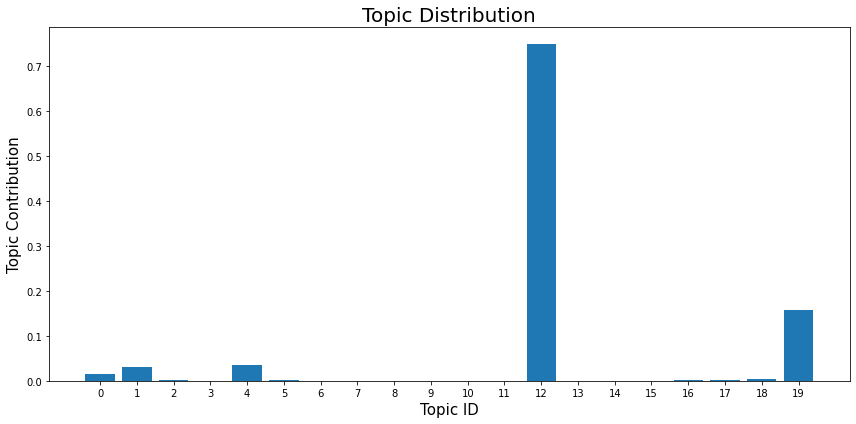

In [ ]:
random_document = training_documents_df.sample(1, random_state = RANDOM_SEED) ['tokenized_document'].squeeze()

print(random_document)

random_doc_topics_distribution = text_tokens_to_topics_distributions(random_document, lda_model, dictionary)

print(random_doc_topics_distribution)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(np.arange(len(random_doc_topics_distribution)), random_doc_topics_distribution)

ax.set_xlabel('Topic ID', fontsize=15)

ax.set_ylabel('Topic Contribution', fontsize=15)

ax.set_title("Topic Distribution", fontsize=20)

ax.set_xticks(np.linspace(0, LDA_NUM_TOPICS-1, LDA_NUM_TOPICS))

fig.tight_layout()

plt.show()

## Load tokenized documents / summaries

In [ ]:
modelling_data_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'tokenized_modelling_documents_and_summaries.pkl'))

print(modelling_data_df.shape)

modelling_data_df.head()

(1997, 4)


,document_file_name,summary_file_name,tokenized_document,tokenized_summary
0,7522.txt,7522_3.txt,"[hornbi, plc, annual, report, account, year, e...","[hornbi, plc, annual, report, account, chairma..."
1,1111.txt,1111_2.txt,"[api, group, plc, annual, report, api, group, ...","[api, group, plc, annual, report, overview, st..."
2,7029.txt,7029_3.txt,"[advanc, fluid, handl, system, ship, offshor, ...","[hamworthi, plc, annual, report, account, resu..."
3,3203.txt,3203_2.txt,"[moorgat, london, ecr, ar, annual, report, fee...","[year, rapid, profit, growth, combin, invest, ..."
4,14694.txt,14694_3.txt,"[sportingbet, plc, annual, report, annual, rep...","[sportingbet, plc, annual, report, overview, c..."


## Generate topics distributions for summaries / documents

In [ ]:
modelling_data_df['document_distributions'] = modelling_data_df['tokenized_document'].swifter.apply(text_tokens_to_topics_distributions, args=(lda_model, dictionary))

modelling_data_df['summary_distributions'] = modelling_data_df['tokenized_summary'].swifter.apply(text_tokens_to_topics_distributions, args=(lda_model, dictionary))

print(modelling_data_df.shape)

modelling_data_df.head()


(1997, 6)


,document_file_name,summary_file_name,tokenized_document,tokenized_summary,document_distributions,summary_distributions
0,7522.txt,7522_3.txt,"[hornbi, plc, annual, report, account, year, e...","[hornbi, plc, annual, report, account, chairma...","[0.032859977, 0.79029083, 0.024872681, 0.00255...","[0.071941905, 0.5763787, 0.1307015, 0.04158506..."
1,1111.txt,1111_2.txt,"[api, group, plc, annual, report, api, group, ...","[api, group, plc, annual, report, overview, st...","[0.18191493, 0.016382702, 0.0033707968, 0.0127...","[0.50325227, 0.00014044944, 0.00014044944, 0.0..."
2,7029.txt,7029_3.txt,"[advanc, fluid, handl, system, ship, offshor, ...","[hamworthi, plc, annual, report, account, resu...","[0.0034466197, 0.16009498, 1.3032372e-06, 0.01...","[2.7382257e-05, 2.7382257e-05, 2.7382257e-05, ..."
3,3203.txt,3203_2.txt,"[moorgat, london, ecr, ar, annual, report, fee...","[year, rapid, profit, growth, combin, invest, ...","[9.398318e-07, 0.06510065, 0.021841252, 0.0012...","[0.00013297872, 0.22594605, 0.00013297872, 0.0..."
4,14694.txt,14694_3.txt,"[sportingbet, plc, annual, report, annual, rep...","[sportingbet, plc, annual, report, overview, c...","[0.049215857, 0.53628325, 0.30541217, 0.037401...","[3.5561872e-05, 0.10266114, 0.8363487, 3.55618..."


# DNN modelling (SAVES RESULTS)

## Create train / test sets

In [ ]:
X = np.array(modelling_data_df['document_distributions'].values.tolist())
y = np.array(modelling_data_df['summary_distributions'].values.tolist())

print(X.shape)
print(y.shape)

(1997, 20)
(1997, 20)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=DNN_TEST_SIZE, random_state = RANDOM_SEED)

print(f"Training set X: {X_train.shape}")
print(f"Testing set X: {X_test.shape}")

print(f"Training set y: {y_train.shape}")
print(f"Testing set y: {y_test.shape}")

Training set X: (1597, 20)
Testing set X: (400, 20)
Training set y: (1597, 20)
Testing set y: (400, 20)


## Scale train / test sets

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train[0])
print(X_test[0])

print(X_train_scaled[0])
print(X_test_scaled[0])

[8.2041640e-03 1.4889451e-02 8.6966204e-03 3.6304942e-03 9.9253014e-04
 7.8166516e-07 1.9086050e-04 5.8317248e-02 4.9959570e-02 6.0462387e-04
 1.4384037e-02 1.3465050e-01 1.3741909e-01 5.0351666e-03 1.6322468e-01
 7.8166516e-07 3.2989186e-01 1.7427749e-03 6.2866189e-02 5.2985689e-03]
[8.2882744e-04 2.7712834e-01 1.1829841e-06 1.1829841e-06 1.1829841e-06
 1.1829841e-06 7.5768419e-02 1.1829841e-06 1.1829841e-06 9.6734287e-03
 1.1829841e-06 1.1829841e-06 2.7475016e-02 1.0344349e-03 1.1829841e-06
 1.1829841e-06 2.6604061e-03 4.5980939e-01 1.1470849e-02 1.3413902e-01]
[-0.37488872 -0.4983558  -0.27436802 -0.28189945 -0.19754498 -0.3502863
 -0.38269314  0.18694997  0.09154915 -0.23259996 -0.15420122  0.7590841
  0.00811244 -0.33903673  1.4189085  -0.2529503   2.397263   -0.35995424
  0.01082424 -0.32991526]
[-0.4207453   0.94427174 -0.33835688 -0.31271276 -0.21021841 -0.3502826
  0.26098758 -0.35154402 -0.32865417 -0.15750434 -0.28606302 -0.3929847
 -0.5321883  -0.36299506 -0.24926671 -0.252

## Build DNN model / Show model summary

In [ ]:
dnn_model = build_dnn_model(DNN_LEARNING_RATE, DNN_HIDDEN_LAYER_UNITS, DNN_DROPOUT_RATE, DNN_L2_REGULARIZAΤΙΟΝ)

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 2,644
Trainable params: 2,644
Non-trainable params: 0
_________________________________________________________________


## Test DNN model output shape

In [ ]:
example_batch = X_train_scaled[:10]

example_result = dnn_model.predict(example_batch)

example_result.shape

(10, 20)

## Train DNN model

In [ ]:
history = dnn_model.fit(X_train_scaled, y_train, epochs=DNN_EPOCHS, validation_split=DNN_VALIDATION_SIZE, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2352,  mae:0.0817,  mse:0.0246,  val_loss:0.1816,  val_mae:0.0811,  val_mse:0.0235,  
....................................................................................................
Epoch: 100, loss:0.0144,  mae:0.0573,  mse:0.0129,  val_loss:0.0127,  val_mae:0.0527,  val_mse:0.0111,  
....................................................................................................
Epoch: 200, loss:0.0130,  mae:0.0536,  mse:0.0117,  val_loss:0.0108,  val_mae:0.0470,  val_mse:0.0095,  
....................................................................................................
Epoch: 300, loss:0.0125,  mae:0.0523,  mse:0.0114,  val_loss:0.0098,  val_mae:0.0449,  val_mse:0.0087,  
....................................................................................................
Epoch: 400, loss:0.0120,  mae:0.0511,  mse:0.0110,  val_loss:0.0093,  val_mae:0.0432,  val_mse:0.0083,  
........................................................................

In [ ]:
hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch

print(hist.head())

print(hist.tail())

       loss       mae       mse  val_loss   val_mae   val_mse  epoch
0  0.235242  0.081685  0.024617  0.181591  0.081051  0.023503      0
1  0.145392  0.080630  0.023235  0.111812  0.080135  0.022889      1
2  0.087726  0.079441  0.022343  0.066780  0.079644  0.022575      2
3  0.052153  0.079047  0.021917  0.040724  0.079517  0.022485      3
4  0.033068  0.079078  0.021865  0.028137  0.079547  0.022522      4
         loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  0.011587  0.049439  0.010775  0.008660  0.040509  0.007850    995
996  0.011456  0.049020  0.010639  0.008934  0.041208  0.008124    996
997  0.011315  0.048954  0.010495  0.008718  0.040424  0.007871    997
998  0.011656  0.049201  0.010820  0.008678  0.040756  0.007866    998
999  0.011884  0.049885  0.011046  0.008833  0.040889  0.007998    999


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE')

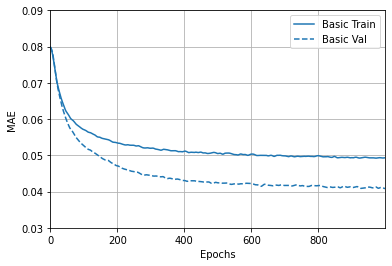

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")

plt.ylim([0.03, 0.09])

plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

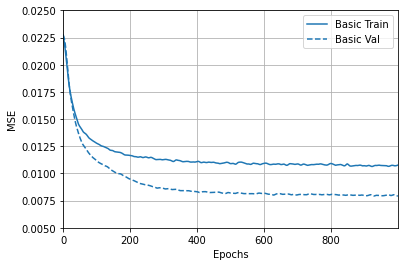

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")

plt.ylim([0.005, 0.025])

plt.ylabel('MSE')

In [ ]:
dnn_model = build_dnn_model(DNN_LEARNING_RATE, DNN_HIDDEN_LAYER_UNITS, DNN_DROPOUT_RATE, DNN_L2_REGULARIZAΤΙΟΝ)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 2,644
Trainable params: 2,644
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=DNN_EARLY_STOPPING_PATIENCE)

early_history = dnn_model.fit(X_train_scaled, y_train, epochs=DNN_EPOCHS, validation_split = DNN_VALIDATION_SIZE, verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2454,  mae:0.0810,  mse:0.0244,  val_loss:0.1903,  val_mae:0.0800,  val_mse:0.0231,  
....................................................................................................
Epoch: 100, loss:0.0137,  mae:0.0554,  mse:0.0120,  val_loss:0.0121,  val_mae:0.0506,  val_mse:0.0105,  
....................................................................................................
Epoch: 200, loss:0.0124,  mae:0.0523,  mse:0.0111,  val_loss:0.0101,  val_mae:0.0450,  val_mse:0.0087,  
..........

Text(0, 0.5, 'MAE')

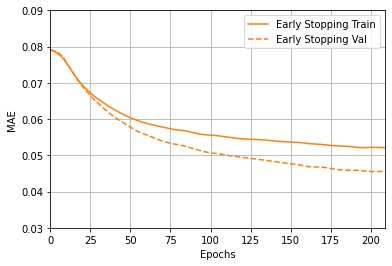

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")

plt.ylim([0.03, 0.09])

plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

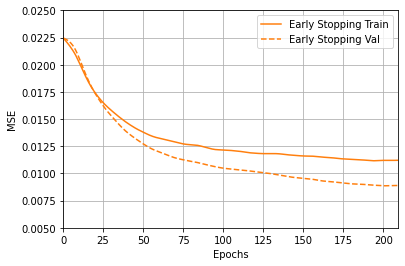

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mse")

plt.ylim([0.005, 0.025])

plt.ylabel('MSE')

## Save DNN model

In [ ]:
dnn_model.save(os.path.join(PROJECT_DIRECTORY_PATH, 'dnn_model.h5'))

## Evaluate test set

In [ ]:
loss, mae, mse = dnn_model.evaluate(X_test_scaled, y_test, verbose=2)

print("Testing set MAE {:5.2f}".format(mae))
print("Testing set MSE {:5.2f}".format(mse))

13/13 - 0s - loss: 0.0104 - mae: 0.0475 - mse: 0.0091
Testing set MAE  0.05
Testing set MSE  0.01


# Load LDA model + Dictionary / DNN model

In [ ]:
dnn_model = tf.keras.models.load_model(os.path.join(PROJECT_DIRECTORY_PATH, 'dnn_model.h5'))

In [ ]:
lda_model = LdaModel.load(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_model.pkl'))

dictionary = corpora.Dictionary.load(os.path.join(PROJECT_DIRECTORY_PATH, 'lda_dictionary.pkl'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Preprocess testing documents (SAVES RESULTS)

## Get documents file paths

In [ ]:
testing_documents_path = os.path.join(EXTRACTED_DATASET_DIRECTORY_PATH, 'testing', 'documents')

testing_document_files = get_file_paths (testing_documents_path)

## Load documents to a dataframe

In [ ]:
testing_documents = load_text_files(testing_document_files, TEXT_ENCODING)

testing_data_df = pd.DataFrame({ 'file_name' : testing_document_files, 'original_document' : testing_documents })

testing_data_df['file_name'] = testing_data_df['file_name'].swifter.apply(lambda o: f'{Path(o).stem}_summary.txt')

print(testing_data_df.shape)

testing_data_df.head()


(500, 2)


,file_name,original_document
0,25082_summary.txt,The environmental \ninvestment specialist\nI...
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...


## Preprocess documents

In [ ]:
testing_data_df['tokenized_document'] = testing_data_df['original_document'].swifter.apply(preprocess_text, args=(stemmer, stop_words, TEXT_ENCODING, re_printable, re_punctuation))

print(testing_data_df.shape)

testing_data_df.head()


(500, 3)


,file_name,original_document,tokenized_document
0,25082_summary.txt,The environmental \ninvestment specialist\nI...,"[environment, invest, specialist, impax, asset..."
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...,"[impellam, group, plc, annual, report, account..."
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...,"[deliv, strategi, annual, report, account, con..."
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...,"[imperi, innov, imperi, innov, group, plc, ann..."
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...,"[nur, ture, innov, annual, report, account, im..."


## Generate topics distributions for documents

In [ ]:
testing_data_df['document_distributions'] = testing_data_df['tokenized_document'].swifter.apply(text_tokens_to_topics_distributions, args=(lda_model, dictionary))

print(testing_data_df.shape)

testing_data_df.head()


(500, 4)


,file_name,original_document,tokenized_document,document_distributions
0,25082_summary.txt,The environmental \ninvestment specialist\nI...,"[environment, invest, specialist, impax, asset...","[0.16202262, 0.12794012, 0.015163482, 0.004628..."
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...,"[impellam, group, plc, annual, report, account...","[0.05516513, 0.023844916, 0.2971211, 0.0291927..."
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...,"[deliv, strategi, annual, report, account, con...","[0.0112099275, 0.0086386, 0.011459767, 0.02302..."
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...,"[imperi, innov, imperi, innov, group, plc, ann...","[0.01843256, 0.013293077, 0.03473317, 0.000508..."
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...,"[nur, ture, innov, annual, report, account, im...","[0.06927553, 0.0015632923, 0.010289794, 0.0421..."


## Generate ideal summary topics distributions for documents

In [ ]:
testing_data_df['summary_distributions'] = testing_data_df['document_distributions']

ideal_summary_distributions = np.round(dnn_model.predict(np.array(testing_data_df['document_distributions'].values.tolist())), PROBABILITY_ROUND_PRECISION)

for i in range(len(ideal_summary_distributions)): testing_data_df.loc[i, 'summary_distributions'] = ideal_summary_distributions[i]

print(testing_data_df.shape)

testing_data_df.head()

(500, 5)


,file_name,original_document,tokenized_document,document_distributions,summary_distributions
0,25082_summary.txt,The environmental \ninvestment specialist\nI...,"[environment, invest, specialist, impax, asset...","[0.16202262, 0.12794012, 0.015163482, 0.004628...","[0.0757062, 0.0714612, 0.0405828, 0.0527269, 0..."
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...,"[impellam, group, plc, annual, report, account...","[0.05516513, 0.023844916, 0.2971211, 0.0291927...","[0.0684698, 0.0721892, 0.0540615, 0.0553748, 0..."
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...,"[deliv, strategi, annual, report, account, con...","[0.0112099275, 0.0086386, 0.011459767, 0.02302...","[0.0645364, 0.0646662, 0.0362514, 0.0571922, 0..."
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...,"[imperi, innov, imperi, innov, group, plc, ann...","[0.01843256, 0.013293077, 0.03473317, 0.000508...","[0.0640066, 0.0615492, 0.0345692, 0.0517259, 0..."
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...,"[nur, ture, innov, annual, report, account, im...","[0.06927553, 0.0015632923, 0.010289794, 0.0421...","[0.0676319, 0.0606817, 0.0329012, 0.0540099, 0..."


## Save preprocessed documents

In [ ]:
testing_data_df.to_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'preprocessed_testing_documents.pkl'))

# Handle testing documents

## Load preprocessed documents

In [ ]:
testing_data_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'preprocessed_testing_documents.pkl'))

print(testing_data_df.shape)

testing_data_df.head()

(500, 5)


,file_name,original_document,tokenized_document,document_distributions,summary_distributions
0,25082_summary.txt,The environmental \ninvestment specialist\nI...,"[environment, invest, specialist, impax, asset...","[0.16202262, 0.12794012, 0.015163482, 0.004628...","[0.0757062, 0.0714612, 0.0405828, 0.0527269, 0..."
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...,"[impellam, group, plc, annual, report, account...","[0.05516513, 0.023844916, 0.2971211, 0.0291927...","[0.0684698, 0.0721892, 0.0540615, 0.0553748, 0..."
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...,"[deliv, strategi, annual, report, account, con...","[0.0112099275, 0.0086386, 0.011459767, 0.02302...","[0.0645364, 0.0646662, 0.0362514, 0.0571922, 0..."
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...,"[imperi, innov, imperi, innov, group, plc, ann...","[0.01843256, 0.013293077, 0.03473317, 0.000508...","[0.0640066, 0.0615492, 0.0345692, 0.0517259, 0..."
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...,"[nur, ture, innov, annual, report, account, im...","[0.06927553, 0.0015632923, 0.010289794, 0.0421...","[0.0676319, 0.0606817, 0.0329012, 0.0540099, 0..."


## Find closest text section as summary on documents

In [ ]:
testing_data_df['summary'] = testing_data_df.swifter.apply(find_summary_text, args=(lda_model, dictionary, stemmer, alphabetical_word_tokenizer, normal_word_tokenizer, stop_words, TEXT_ENCODING, SUMMARY_MINIMUM_TEXT_HALF_LENGTH, SUMMARY_MINIMUM_N_ALPHABETICAL_WORDS, SUMMARY_MAXIMUM_N_WORDS, re_printable, re_punctuation), axis=1)

print(testing_data_df.shape)

testing_data_df.head()


(500, 6)


,file_name,original_document,tokenized_document,document_distributions,summary_distributions,summary
0,25082_summary.txt,The environmental \ninvestment specialist\nI...,"[environment, invest, specialist, impax, asset...","[0.16202262, 0.12794012, 0.015163482, 0.004628...","[0.0757062, 0.0714612, 0.0405828, 0.0527269, 0...",From \nits inception on 3 March 2008 to 30 \nS...
1,25110_summary.txt,Impellam Group plc \nAnnual Report and Accou...,"[impellam, group, plc, annual, report, account...","[0.05516513, 0.023844916, 0.2971211, 0.0291927...","[0.0684698, 0.0721892, 0.0540615, 0.0553748, 0...",These are non-IFRS measures. For further \ninf...
2,25111_summary.txt,DELIVERING AGAINST \nOUR STRATEGY\nANNUAL REP...,"[deliv, strategi, annual, report, account, con...","[0.0112099275, 0.0086386, 0.011459767, 0.02302...","[0.0645364, 0.0646662, 0.0362514, 0.0571922, 0...",He was also a member of both the UK and German...
3,25118_summary.txt,imperial \ninnovations\nImperial Innovations ...,"[imperi, innov, imperi, innov, group, plc, ann...","[0.01843256, 0.013293077, 0.03473317, 0.000508...","[0.0640066, 0.0615492, 0.0345692, 0.0517259, 0...",The agreements by which such options were gran...
4,25120_summary.txt,Nur turing \n innovation\nAnnual Report and...,"[nur, ture, innov, annual, report, account, im...","[0.06927553, 0.0015632923, 0.010289794, 0.0421...","[0.0676319, 0.0606817, 0.0329012, 0.0540099, 0...",Set out below are some examples from our \neng...


## Save summaries on disk as text files

In [ ]:
testing_summaries_directory_path = os.path.join(PROJECT_DIRECTORY_PATH, 'testing-summaries')

os.makedirs(testing_summaries_directory_path, exist_ok=True)

testing_data_df.swifter.apply(save_summary_on_disk, args=(testing_summaries_directory_path, TEXT_ENCODING), axis=1)

print("Test set summaries saved on disk")


Test set summaries saved on disk


# Preprocess evaluation documents (SAVES RESULTS)

## Load documents to a dataframe

In [ ]:
evaluation_data_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'original_evaluation_documents.pkl'))

evaluation_data_df['file_name'] = evaluation_data_df['document_file_name'].swifter.apply(lambda o: f'{Path(o).stem}_summary.txt')

print(evaluation_data_df.shape)

evaluation_data_df.head()


(899, 3)


,document_file_name,original_document,file_name
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt


## Preprocess documents

In [ ]:
evaluation_data_df['tokenized_document'] = evaluation_data_df['original_document'].swifter.apply(preprocess_text, args=(stemmer, stop_words, TEXT_ENCODING, re_printable, re_punctuation))

print(evaluation_data_df.shape)

evaluation_data_df.head()


(899, 4)


,document_file_name,original_document,file_name,tokenized_document
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt,"[annual, report, financi, statement, annual, r..."
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt,"[yule, catto, co, plc, annual, report, year, e..."
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt,"[fiberweb, plc, annual, report, financi, st, a..."
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt,"[annual, report, account, southern, cross, hea..."
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt,"[annual, report, account, booker, group, plc, ..."


## Generate topics distributions for documents

In [ ]:
evaluation_data_df['document_distributions'] = evaluation_data_df['tokenized_document'].swifter.apply(text_tokens_to_topics_distributions, args=(lda_model, dictionary))

print(evaluation_data_df.shape)

evaluation_data_df.head()


(899, 5)


,document_file_name,original_document,file_name,tokenized_document,document_distributions
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt,"[annual, report, financi, statement, annual, r...","[0.07125156, 0.00847639, 0.36051184, 0.0029876..."
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt,"[yule, catto, co, plc, annual, report, year, e...","[0.008204781, 0.023837263, 0.010924666, 0.0007..."
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt,"[fiberweb, plc, annual, report, financi, st, a...","[0.0035660828, 0.002509876, 0.011353975, 0.006..."
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt,"[annual, report, account, southern, cross, hea...","[0.34472367, 0.08448045, 0.0033785729, 6.93375..."
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt,"[annual, report, account, booker, group, plc, ...","[0.41871575, 0.21240936, 0.00011967635, 0.0044..."


## Generate ideal summary topics distributions for documents

In [ ]:
evaluation_data_df['summary_distributions'] = evaluation_data_df['document_distributions']

ideal_summary_distributions = np.round(dnn_model.predict(np.array(evaluation_data_df['document_distributions'].values.tolist())), PROBABILITY_ROUND_PRECISION)

for i in range(len(ideal_summary_distributions)): evaluation_data_df.loc[i, 'summary_distributions'] = ideal_summary_distributions[i]

print(evaluation_data_df.shape)

evaluation_data_df.head()

(899, 6)


,document_file_name,original_document,file_name,tokenized_document,document_distributions,summary_distributions
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt,"[annual, report, financi, statement, annual, r...","[0.07125156, 0.00847639, 0.36051184, 0.0029876...","[0.0697196, 0.0732441, 0.0575194, 0.0532512, 0..."
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt,"[yule, catto, co, plc, annual, report, year, e...","[0.008204781, 0.023837263, 0.010924666, 0.0007...","[0.0684704, 0.0564991, 0.0363201, 0.0543203, 0..."
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt,"[fiberweb, plc, annual, report, financi, st, a...","[0.0035660828, 0.002509876, 0.011353975, 0.006...","[0.0661962, 0.0642559, 0.0363109, 0.0537944, 0..."
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt,"[annual, report, account, southern, cross, hea...","[0.34472367, 0.08448045, 0.0033785729, 6.93375...","[0.0933158, 0.0731438, 0.0377811, 0.051997, 0...."
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt,"[annual, report, account, booker, group, plc, ...","[0.41871575, 0.21240936, 0.00011967635, 0.0044...","[0.099498, 0.0769386, 0.0369924, 0.0518598, 0...."


## Save preprocessed documents

In [ ]:
evaluation_data_df.to_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'preprocessed_evaluation_documents.pkl'))

# Handle evaluation documents

## Load preprocessed documents

In [ ]:
evaluation_data_df = pd.read_pickle(os.path.join(PROJECT_DIRECTORY_PATH, 'preprocessed_evaluation_documents.pkl'))

print(evaluation_data_df.shape)

evaluation_data_df.head()

(899, 6)


,document_file_name,original_document,file_name,tokenized_document,document_distributions,summary_distributions
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt,"[annual, report, financi, statement, annual, r...","[0.07125156, 0.00847639, 0.36051184, 0.0029876...","[0.0697196, 0.0732441, 0.0575194, 0.0532512, 0..."
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt,"[yule, catto, co, plc, annual, report, year, e...","[0.008204781, 0.023837263, 0.010924666, 0.0007...","[0.0684704, 0.0564991, 0.0363201, 0.0543203, 0..."
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt,"[fiberweb, plc, annual, report, financi, st, a...","[0.0035660828, 0.002509876, 0.011353975, 0.006...","[0.0661962, 0.0642559, 0.0363109, 0.0537944, 0..."
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt,"[annual, report, account, southern, cross, hea...","[0.34472367, 0.08448045, 0.0033785729, 6.93375...","[0.0933158, 0.0731438, 0.0377811, 0.051997, 0...."
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt,"[annual, report, account, booker, group, plc, ...","[0.41871575, 0.21240936, 0.00011967635, 0.0044...","[0.099498, 0.0769386, 0.0369924, 0.0518598, 0...."


## Find closest text section as summary on documents

In [ ]:
evaluation_data_df['summary'] = evaluation_data_df.swifter.apply(find_summary_text, args=(lda_model, dictionary, stemmer, alphabetical_word_tokenizer, normal_word_tokenizer, stop_words, TEXT_ENCODING, SUMMARY_MINIMUM_TEXT_HALF_LENGTH, SUMMARY_MINIMUM_N_ALPHABETICAL_WORDS, SUMMARY_MAXIMUM_N_WORDS, re_printable, re_punctuation), axis=1)

# For baseline results: evaluation_data_df['summary'] = evaluation_data_df.swifter.apply(baseline_find_summary_text, args=(alphabetical_word_tokenizer, normal_word_tokenizer, SUMMARY_MINIMUM_TEXT_HALF_LENGTH, SUMMARY_MINIMUM_N_ALPHABETICAL_WORDS, SUMMARY_MAXIMUM_N_WORDS), axis=1)

print(evaluation_data_df.shape)

evaluation_data_df.head()


(899, 7)


,document_file_name,original_document,file_name,tokenized_document,document_distributions,summary_distributions,summary
0,3545.txt,Annual Report and financial statements 2014 ...,3545_summary.txt,"[annual, report, financi, statement, annual, r...","[0.07125156, 0.00847639, 0.36051184, 0.0029876...","[0.0697196, 0.0732441, 0.0575194, 0.0532512, 0...",He was Chairman of the Association \nof Ophtha...
1,15276.txt,Yule Catto & Co plc\nAnnual Report\nFor the y...,15276_summary.txt,"[yule, catto, co, plc, annual, report, year, e...","[0.008204781, 0.023837263, 0.010924666, 0.0007...","[0.0684704, 0.0564991, 0.0363201, 0.0543203, 0...",With the \ndecline in the economy and the scar...
2,5941.txt,Fiberweb plc\nAnnuAl report \nAnd FinAnciAl S...,5941_summary.txt,"[fiberweb, plc, annual, report, financi, st, a...","[0.0035660828, 0.002509876, 0.011353975, 0.006...","[0.0661962, 0.0642559, 0.0363109, 0.0537944, 0...",Fiberweb Geosynthetics deployed the Defencell ...
3,14547.txt,Annual Report and Accounts 2010\nSouthern Cro...,14547_summary.txt,"[annual, report, account, southern, cross, hea...","[0.34472367, 0.08448045, 0.0033785729, 6.93375...","[0.0933158, 0.0731438, 0.0377811, 0.051997, 0....","Between 2002 and May 2008, \nMr Buchan, backed..."
4,17939.txt,ANNUAL REPORT & ACCOUNTS 2015\nBOOKER GROUP P...,17939_summary.txt,"[annual, report, account, booker, group, plc, ...","[0.41871575, 0.21240936, 0.00011967635, 0.0044...","[0.099498, 0.0769386, 0.0369924, 0.0518598, 0....",The members’ attendance record was as follows:...


## Save summaries on disk as text files

In [ ]:
evaluation_summaries_directory_path = os.path.join(PROJECT_DIRECTORY_PATH, 'evaluation-summaries')

os.makedirs(evaluation_summaries_directory_path, exist_ok=True)

evaluation_data_df.swifter.apply(save_summary_on_disk, args=(evaluation_summaries_directory_path, TEXT_ENCODING), axis=1)

print("Evaluation set summaries saved on disk")


Evaluation set summaries saved on disk


# THE END